In [1]:
from IPython.display import Image

- references
    - https://www.youtube.com/watch?v=KmqTrm-bn8k

In [2]:
Image(url='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*3nBb4AqcriLcENdpBp4fpQ@2x.png')

### reject sampling recap


> generate observations from a distribution.

- target distribution vs. candidate distribution (proposal distribution)
    $$
    p(s)=\frac{f(s)}{NC}
    $$
    - NC：Normalizing constant（是分子部分的积分，$\int f(s)ds$）
        - reduce any **probability function** to a **probability density function**(PDF) with total probability of one.
    - 我们不知道目标分布（$p(s)$），只知道 numerator（$f(s)$）
        - $p(s)\propto f(s)$
- reject sampling
    - 选择 $g(s)$ 跟 $p(s)$ 很接近，且易采样；
    - scale $g(s)$ by M, 确保 $M\cdot g(s)\geq f(s)$
    - algorithm
        - sample $s$ from $g(s)$
        - accept ratio: $\frac{f(s)}{Mg(s)}$（一定是 <= 1 的）
        - 可以做一个简单的推导（$D(s|A)$，given accepted，这个样本 $s$ 是 $p(s)$ 的样本的 density）
            - $D(s|A)=\frac{P(A|s)D(s)}{P(A)}=\frac{\frac{f(s)}{Mg(s)}g(s)}{P(A)}$
                - $P(A)=\int g(s)\frac{f(s)}{Mg(s)}ds=\frac1M\int f(s)ds=\frac{NC}M$
            - $D(s|A)=\frac{f(s)/M}{NC/M}=f(s)/NC=p(s)$
    - M 越大，accept rate（$P(A)$）越低，意味着采样效率（inefficient）


### mcmc basics

- reject sampling 的问题
    - $g$ 的选择（要 easy to sample）
    - 很容易导致 $M$ 会很大，$p(A)=\frac{NC}{M}$ 进一步导致 sampling 的 inefficient；
    - **samples are uncorrelated**
        - 完全独立地sample；
- MCMC (Markov Chain Monte Carlo)
    - Markov Chain & Monte Carlo simulation
        - 不再是独立地 sample，learning from the previous samples
        - next sample depends on last
        - 即沿着 Markov Chain 进行 Monte Carlo simulation
    - Metropolis Hastings

```mermaid
flowchart LR
    classDef circleStyle fill:#f9f,stroke:#333,stroke-width:2px,rx:15px,ry:15px;
    x0 --> x1
    x1 --> x2
    x2 --> x3
    class x0,x1,x2,x3 circleStyle;
```

In [3]:
Image(url='https://miro.medium.com/v2/resize:fit:640/format:webp/1*Hc6u4frwjbgdnVFFUlqxvw.png', width=400)

- goal stationary distribution
    - stationary state (distribution) is the $p(x)$
    - $pT=p$
- design transition probs（如下的细致平稳条件，detailed balance）
    - $p(x)T(y|x)=p(y)T(x|y),\forall x,y$
    - 保证我们构造的 markov chain 的稳态分布就是我们要的目标分布 $p(x)$
    - 在稳态时，从 $x$ 跳到 $y$ 的概率，和从 $y$ 跳到 $x$ 的概率流是相等的；
    - 在 Metropolis-Hastings 等算法中，通过适当设计接受率（acceptance probability），就可以让这个条件成立，从而在收敛之后，得到的采样分布就是我们的目标分布。

### Metropolis - Hastings

- 算法的
    - 设计 Transition $g(x_{t+1}|x_t)\sim \mathcal N(x_t,\sigma^2)$
    - accept prob: $A(x_t \rightarrow x_{t+1})$
        - 现在考虑细致平稳条件，for all $a,b$
        - $p(a)T(a\rightarrow b)=p(b) T(b\rightarrow a)$
        - $\frac{f(a)}{NC}g(b|a)A(a\rightarrow b)=\frac{f(b)}{NC}g(a|b)A(b\rightarrow a)$
        - $\frac{A(a\rightarrow b)}{A(b \rightarrow a)}=\frac{f(b)}{f(a)}\frac{g(a|b)}{g(b|a)}=r_f\cdot r_g$
        - 此时
            - 如果 $r_f\cdot r_g\lt 1$，则 $A(b\rightarrow a)=1, A(a\rightarrow b)=r_f\cdot r_g$
            - 如果 $r_f\cdot r_g\geq 1$，则 $A(a\rightarrow b)=1, A(b\rightarrow a)=\frac{1}{r_f\cdot r_g}$
            - 因此 $A(a\rightarrow b)=\min(1,r_f\cdot r_g)$
        - mh 算法要求 $g$ 是对称，也即 symmetric 的会有
            - $g(a|b)=g(b|a)$
                - 以正态分布为例，$g(a|b)=\mathcal N(a;b,\sigma^2)=\frac1{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(a-b)^2}{2\sigma^2}\right)=g(b|a)$
            - 因此有 $A(a\rightarrow b)=\min(1,r_f)=\min(1,\frac{f(b)}{f(a)})=\min(1,\frac{p(b)}{p(a)})$
                - 如果 $p(b)\gt p(a)$, 则有 $A(a\rightarrow b)=1$
                - 如果 $p(b)\lt p(a)$，则有 $A(a\rightarrow b)=\frac{p(b)}{p(a)}$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy

In [4]:
# this function is the numerator of the target distribution
# 分子部分
def f(x):
    if x >= 1:
        return np.exp(-(x-1)/2) + np.exp(-(x-1)**2)
    return np.exp((x-1)/3) + np.exp((x-1)**3)

In [5]:
NORMALIZER = scipy.integrate.quad(f, -np.inf, np.inf)[0]

In [6]:
NORMALIZER

6.7792064370220055

## target distribution ($p(x)$)

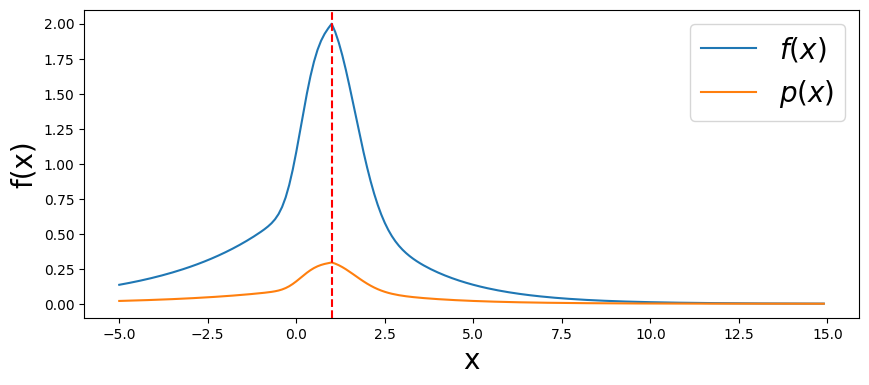

In [7]:
x_vals = np.arange(-5, 15, .1)
f_vals = [f(x) for x in x_vals]
p_vals = [f/NORMALIZER for f in f_vals]

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, p_vals)
plt.legend(['$f(x)$', '$p(x)$'], fontsize=20)
plt.xlabel('x', fontsize=20)
plt.ylabel('f(x)', fontsize=20)
plt.axvline(1, color='r', linestyle='--')

In [8]:
sum(p_vals)

9.409292472410552

In [9]:
# 基于梯形规则（trapezoidal rule）对离散数据进行积分计算
np.trapz(p_vals, x_vals)

0.9399240121913706

$$
\sum_{a}^bf(x)dx\approx\sum_{i=1}^{n-1}\frac12(x_{i+1}-x_i)\cdot(f(x_{i+1})+f(x_i))
$$

In [10]:
area = 0
for i in range(1, len(x_vals)):
    dx = x_vals[i] - x_vals[i-1]
    area += 0.5 * dx * (p_vals[i] + p_vals[i-1])
area

0.9399240121913707

In [11]:
true_mu = scipy.integrate.quad(lambda x: x*f(x)/NORMALIZER, -np.inf, np.inf)[0]
true_mu

0.26962356251087716

## case1: Acept-Reject with $\mathcal N(0, 3)$

In [12]:
# normal PDF
def g(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-(x-mu)**2/sigma**2/2)

In [47]:
x_vals = np.arange(-30,30,.1)
f_vals = [f(x) for x in x_vals]
g_vals = g(x_vals, 0, 3)

Text(0.5, 1.0, 'M=1')

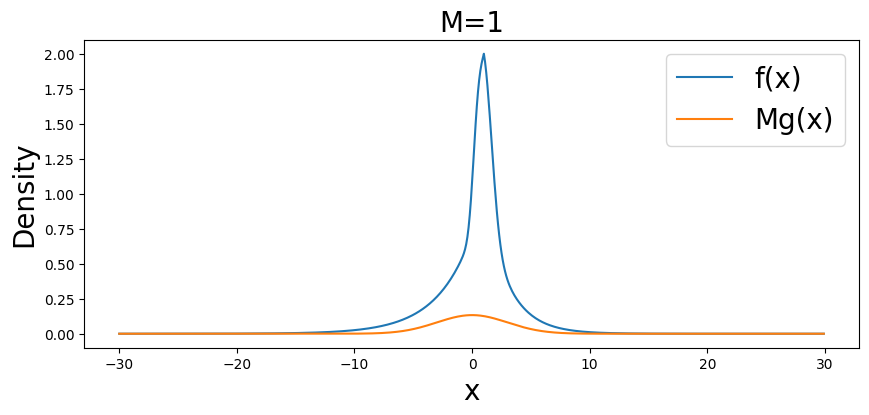

In [13]:

M = 1

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['f(x)', 'Mg(x)'], fontsize=20)

plt.title("M=%s"%M, fontsize=20)

Text(0.5, 1.0, 'M=10')

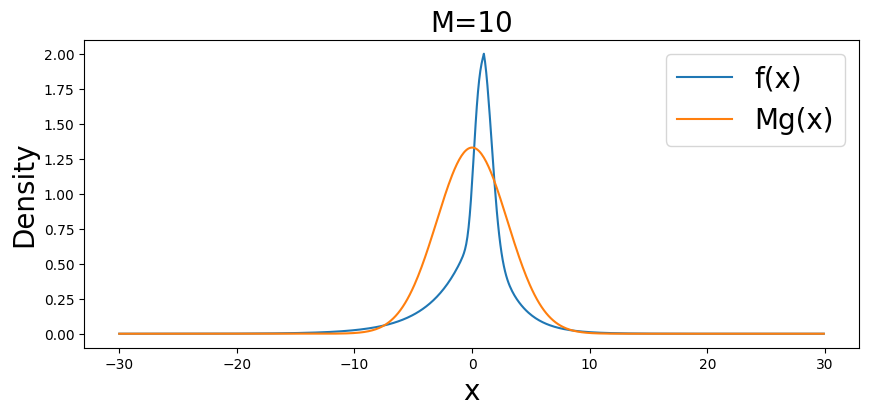

In [14]:
x_vals = np.arange(-30,30,.1)
f_vals = [f(x) for x in x_vals]
g_vals = g(x_vals, 0, 3)
M = 10

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['f(x)', 'Mg(x)'], fontsize=20)

plt.title("M=%s"%M, fontsize=20)

In [51]:
np.max(f_vals / g_vals) * 1.1 

1.3951417101500608e+18

Text(0.5, 1.0, 'M=1000')

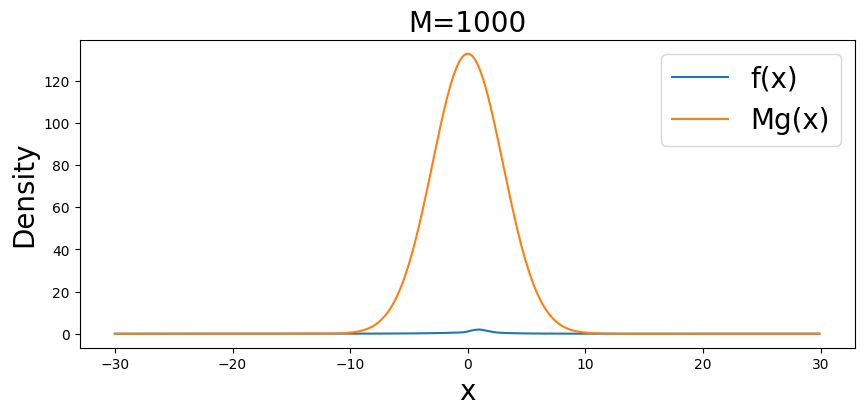

In [15]:
M = 1000

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['f(x)', 'Mg(x)'], fontsize=20)

plt.title("M=%s"%M, fontsize=20)

# plt.ylim(0,1)

In [16]:
np.sum(M*g_vals >= f_vals), len(f_vals)

(276, 600)

(0.0, 0.05)

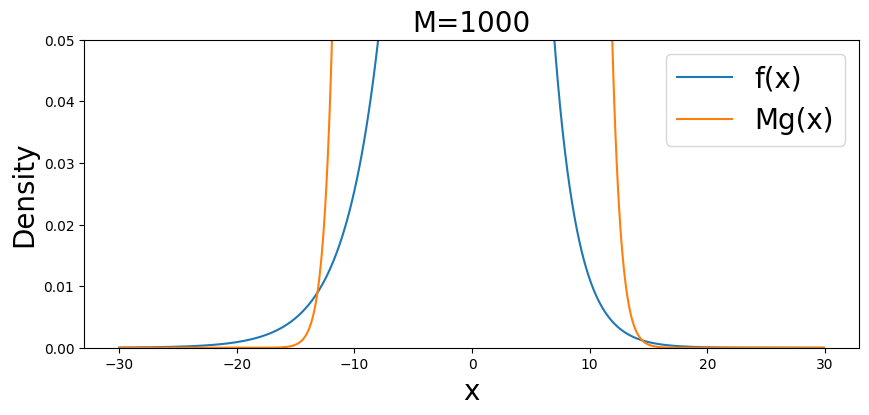

In [17]:
M = 1000

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['f(x)', 'Mg(x)'], fontsize=20)

plt.title("M=%s"%M, fontsize=20)

plt.ylim(0,.05)

In [18]:
from tqdm.notebook import tqdm

In [19]:
M

1000

In [20]:
#collect all accepted samples here
samples = []
#try this many candidates
N = 1_000_000

for _ in tqdm(range(N)):
    #sample a candidate
    candidate = np.random.normal(0, 3)
    
    #calculate probability of accepting this candidate
    prob_accept = f(candidate) / (M*g(candidate, 0, 3))
    
    #accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [21]:
len(samples)*1./N

0.006756

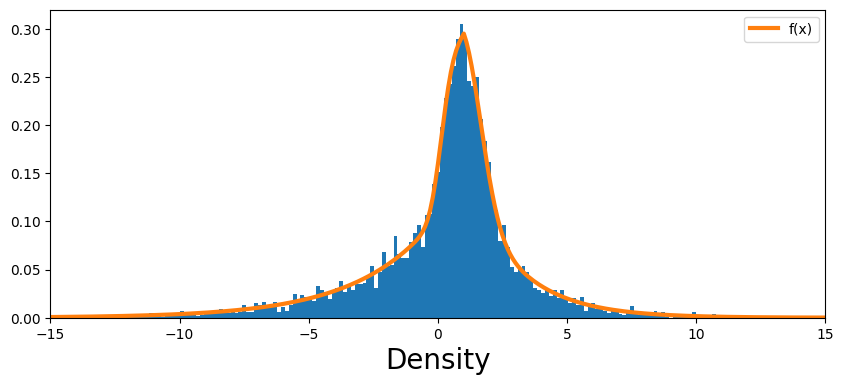

In [22]:
plt.figure(figsize=(10,4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f/NORMALIZER for f in f_vals], linewidth=3, label='f(x)')
plt.xlim(-15,15)
plt.legend()

Text(0.5, 1.0, 'Correlation: -0.01')

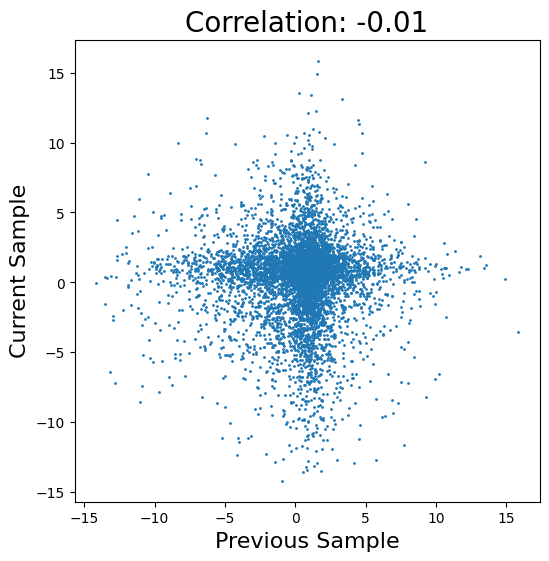

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(samples[:-1], samples[1:], s=1)
plt.xlabel('Previous Sample', fontsize=16)
plt.ylabel('Current Sample', fontsize=16)
corr = round(stats.pearsonr(samples[:-1], samples[1:])[0], 2)
plt.title('Correlation: %s'%corr, fontsize=20)

## Case 2 : Accept-Reject with $\mathcal N(1,4)$ Candidate

Text(0.5, 1.0, 'M=1')

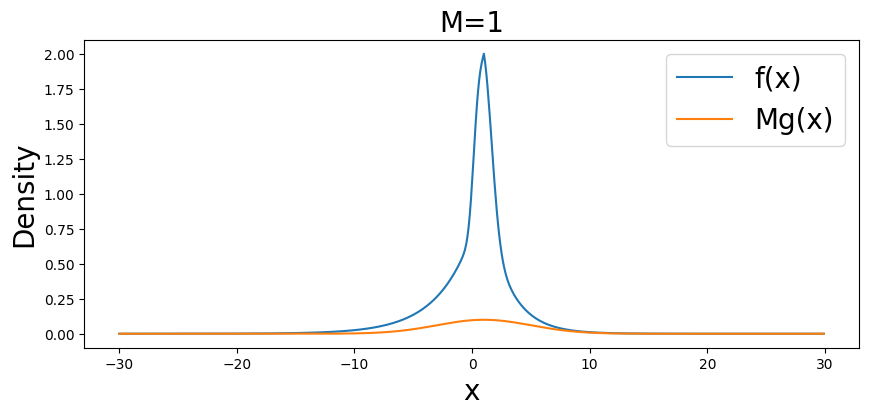

In [24]:
x_vals = np.arange(-30,30,.1)
f_vals = [f(x) for x in x_vals]
g_vals = g(x_vals, 1, 4)
M = 1

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['f(x)', 'Mg(x)'], fontsize=20)

plt.title("M=%s"%M, fontsize=20)

Text(0.5, 1.0, 'M=75')

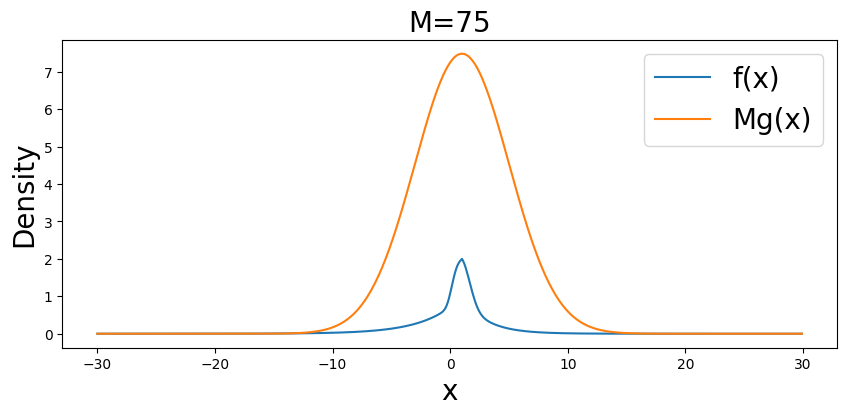

In [25]:
M = 75

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['f(x)', 'Mg(x)'], fontsize=20)

plt.title("M=%s"%M, fontsize=20)

In [41]:
samples = []
N = 1_000_000
for _ in tqdm(range(N)):
    #get a candidate from uniform distribution
    candidate = np.random.normal(1, 4)
    
    #calculate probabailty of accepting this sample
    prob_accept = f(candidate) / (M*g(candidate, 1, 4))
    
    #accept sample with this probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [37]:
len(samples)*1./N

0.089814

(-15.0, 15.0)

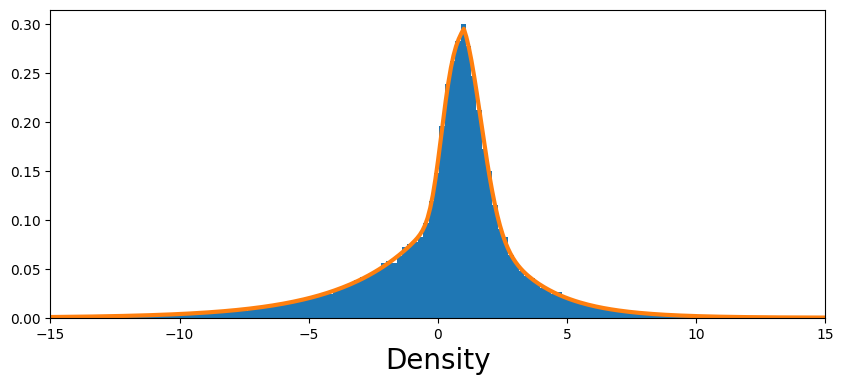

In [38]:
plt.figure(figsize=(10,4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f/NORMALIZER for f in f_vals], linewidth=3)
plt.xlim(-15,15)

Text(0.5, 1.0, 'Correlation: -0.01')

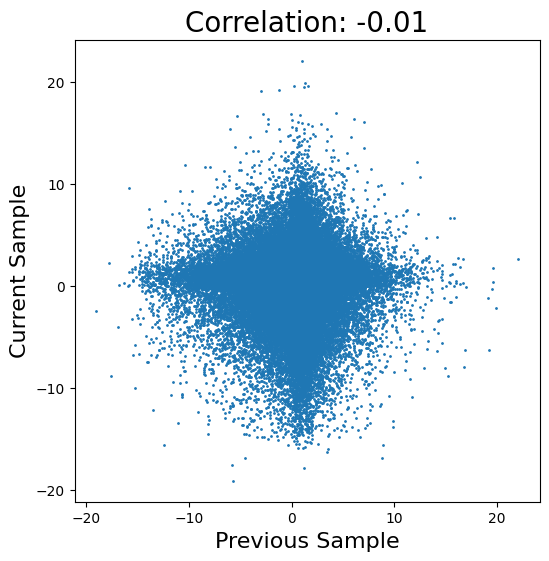

In [39]:
plt.figure(figsize=(6,6))
plt.scatter(samples[:-1], samples[1:], s=1)
plt.xlabel('Previous Sample', fontsize=16)
plt.ylabel('Current Sample', fontsize=16)
corr = round(stats.pearsonr(samples[:-1], samples[1:])[0], 2)
plt.title('Correlation: %s'%corr, fontsize=20)

## Case 3 : Metropolis Algorithm with $\mathcal N(x_{\text{prev}}, 4)$ Candidate (MCMC)

In [42]:
samples = [1]
num_accept = 0
N = 1_000_000
for _ in tqdm(range(N)):
    #sample candidate from normal distribution
    candidate = np.random.normal(samples[-1], 4)
    
    #calculate probability of accepting this candidate
    prob = min(1, f(candidate) / f(samples[-1]))
    
    #accept with the calculated probability
    if np.random.random() < prob:
        samples.append(candidate)
        num_accept += 1
        
    #otherwise report current sample again
    else:
        samples.append(samples[-1])

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [43]:
burn_in = 1000
retained_samples = samples[burn_in+1:]

In [44]:
len(retained_samples)*1./ N

0.999

(-15.0, 15.0)

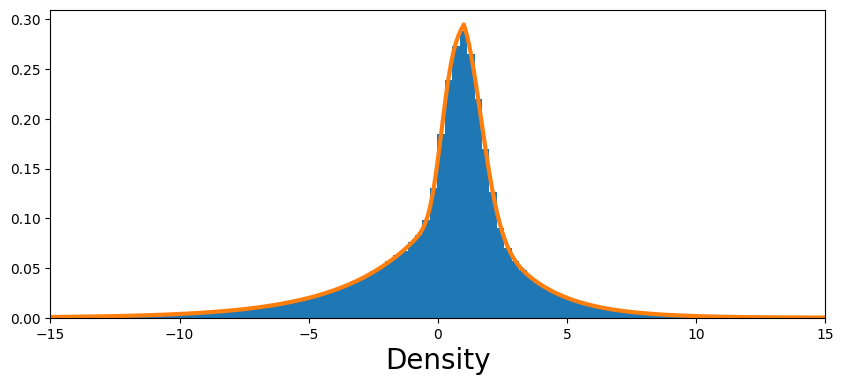

In [45]:
plt.figure(figsize=(10,4))
plt.hist(retained_samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f/NORMALIZER for f in f_vals], linewidth=3)
plt.xlim(-15,15)

Text(0.5, 1.0, 'Correlation: 0.81')

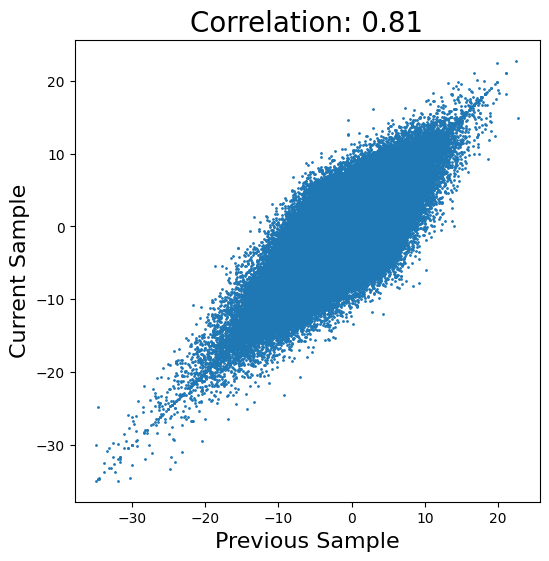

In [46]:
plt.figure(figsize=(6,6))
plt.scatter(retained_samples[:-1], retained_samples[1:], s=1)
plt.xlabel('Previous Sample', fontsize=16)
plt.ylabel('Current Sample', fontsize=16)
corr = round(stats.pearsonr(samples[:-1], samples[1:])[0], 2)
plt.title('Correlation: %s'%corr, fontsize=20)